In [3]:
%load_ext autoreload
%autoreload 2

import sys

## NB! Sul on vaja seda alumist repot! 
## Mine siia, klooni see kausta, kus sul kõik teised repod
## https://bitbucket.org/iacsimgro/pykdgrav3_utils/src/master/

sys.path.insert(0,'C:/Users/dnurm/repos')
from pykdgrav3_utils import units
u = units.units(1, 600., verbose=True)

import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import h5py
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: cannot import name 'units' from 'pykdgrav3_utils' (unknown location)

In [ ]:
# See funktsioon händelib snap-faili laadimise
def load_snap_file(path, part_type='PartType1', is_print = False):

    snap_file = h5py.File(path, 'r')
    part_data = snap_file[part_type]

    if(is_print):
        print(f'Loading snapshot: {path.split("/")[-1]}')
        print(f'Selected species: {part_type}')
        print(f'Snap file keys: {snap_file.keys()}')
        print(f'Part type keys: {part_data.keys()}')

    return part_data

In [ ]:
# Siia läheb sinu faili path!!
snap_path = ''

# Annab tumeaine
snap_dm = load_snap_file(snap_path, is_print=True)

# Annab tähed
snap_stars = load_snap_file(snap_path, part_type='PartType4', is_print=True)

Loading snapshot: dm_sim.00002.0
Selected species: PartType1
Snap file keys: <KeysViewHDF5 ['Cosmology', 'Header', 'Parameters', 'PartType1', 'PartType4', 'Units']>
Part type keys: <KeysViewHDF5 ['Coordinates', 'Density', 'GroupID', 'Masses', 'ParticleIDs', 'Potential', 'Softening', 'Velocities']>
Loading snapshot: dm_sim.00002.0
Selected species: PartType4
Snap file keys: <KeysViewHDF5 ['Cosmology', 'Header', 'Parameters', 'PartType1', 'PartType4', 'Units']>
Part type keys: <KeysViewHDF5 ['Coordinates', 'GroupID', 'Masses', 'ParticleIDs', 'Potential', 'Softening', 'StellarFormationTime', 'Velocities']>


In [ ]:
# See on oluline koht, u.dKpcUnit konverdib koodi sees olevad koordinaadid dKpc ühikusse
pos_dm = snap_dm['Coordinates'][:]*u.dKpcUnit
pos_stars = snap_stars['Coordinates'][:]*u.dKpcUnit

In [ ]:
# Selekteerib kõik osakesed, mille z-koordinaat on -60 < z < 60 dKpc

z_mask = np.abs(pos_dm[:, 2]) < 60
pos_dm_sliced = pos_dm[z_mask]

z_mask = np.abs(pos_stars[:, 2]) < 60
pos_stars_sliced = pos_stars[z_mask] 

## DM wake

In [ ]:
half_box = 300
bin_width = 2
nbins = int((2 * half_box) / bin_width)

H, xedges, yedges = np.histogram2d(
    pos_dm_sliced[:, 0], 
    pos_dm_sliced[:, 1],
    bins=nbins,
    range=[[-half_box, half_box], [-half_box, half_box]]
)

In [ ]:
# Physical density inside each cell of the histogram
dm_particle_mass = np.unique(snap_dm['Masses'][:])
cell_volume = 2*2*120

H_density = (H*dm_particle_mass)/cell_volume

In [ ]:
# Overdensity
H_overdensity = H_density/np.mean(H_density) - 1

# Rotate to compare with Foote
H_overdensity = np.rot90(H_overdensity, k=3)

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:37: UserWarning: The following kwargs were not used by contour: 'linestyle'


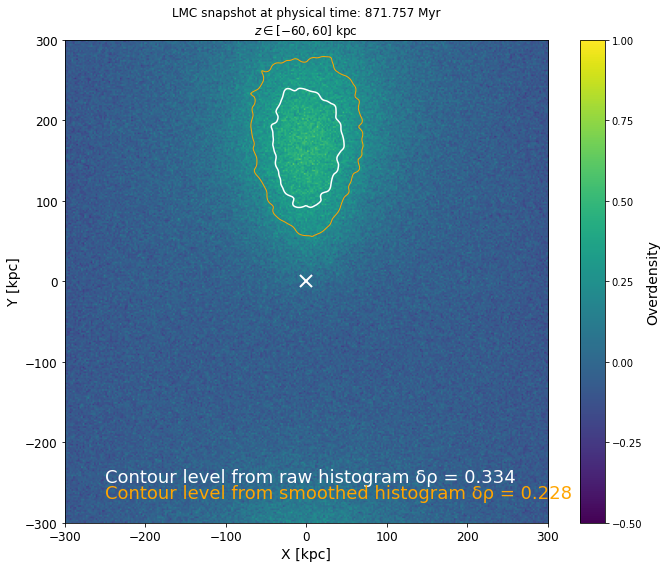

In [ ]:
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Convert σ from kpc to pixels
sigma_kpc = 4.0
sigma_pix = sigma_kpc / bin_width       # -> 2 pixels if bin is 2 kpc

overdensity_smooth = gaussian_filter(H_overdensity, sigma=sigma_pix)

halfmax_level_smoothed = np.max(overdensity_smooth)/2
halfmax_level_simulation = np.max(H_overdensity)/2

fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=False, sharex=True)
im = axs.imshow(H_overdensity.T, origin="lower", extent=extent,cmap='viridis', vmin=-0.50, vmax=1.0)
cbar = fig.colorbar(im)
cbar.set_ticks(np.linspace(-0.5, 1.0, 7)) 

fontdict = {'fontsize' : 14}
cbar.set_label('Overdensity', fontdict=fontdict)
axs.set_xlabel('X [kpc]', fontdict=fontdict)
axs.set_ylabel('Y [kpc]', fontdict=fontdict)
axs.tick_params(axis='both', which='major', labelsize=12)


cs = axs.contour(overdensity_smooth.T, levels=[halfmax_level_simulation], 
                colors='white',
                linewidths=1.5, origin="lower", extent=extent)

cs = axs.contour(overdensity_smooth.T, levels=[halfmax_level_smoothed], 
                colors='orange', linestyle='--',
                linewidths=1.0, origin="lower", extent=extent)


axs.plot(0, 0, marker='x', color='white', markersize=12, markeredgewidth=2)
axs.text(
    -250, -250,                     # data coordinates (x,y in kpc)
    f"Contour level from raw histogram δρ = {halfmax_level_simulation:.3f}", 
    color="white", fontsize=18
)

axs.text(
    -250, -270,                     # data coordinates (x,y in kpc)
    f"Contour level from smoothed histogram δρ = {halfmax_level_smoothed:.3f}", 
    color="orange", fontsize=18
)


fig.tight_layout()

plt.savefig('out_viridis.png', dpi=300)


## Stellar wake

In [ ]:
half_box = 300
bin_width = 2
nbins = int((2 * half_box) / bin_width)

H, xedges, yedges = np.histogram2d(
    pos_stars_sliced[:, 0][::300], 
    pos_stars_sliced[:, 1][::300],
    bins=nbins,
    range=[[-half_box, half_box], [-half_box, half_box]]
)

# Physical density inside each cell of the histogram
star_particle_mass = np.unique(snap_stars['Masses'][:])
cell_volume = 2*2*120

# Physical density
H_density = (H*star_particle_mass)/cell_volume

# Overdensity
H_overdensity = H_density/np.mean(H_density) - 1

# Overdensity with actual mean stellar density
# Stellar density that they quote in Table 2
# **5.818x10^{-3} M⊙kpc−3**
# H_overdensity = H_density/5.818e-3 - 1
 
# Rotate to compare with Foote
H_overdensity = np.rot90(H_overdensity, k=3)

/home/sven/repos/dspn/dspn_env/lib64/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: The following kwargs were not used by contour: 'linestyle'


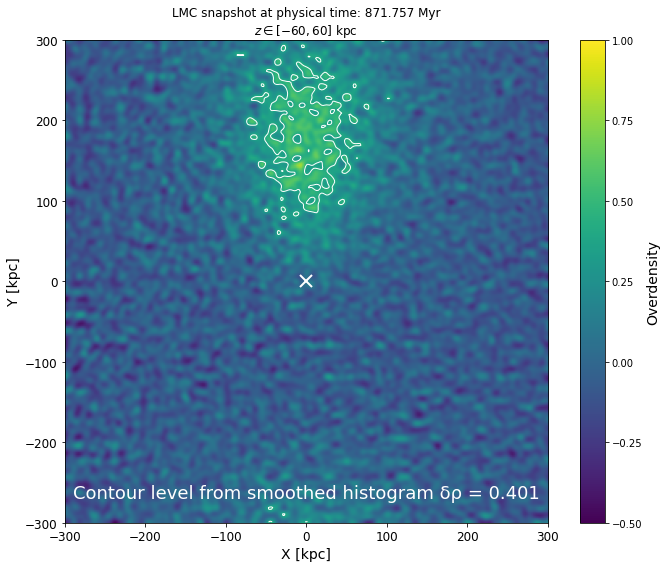

In [ ]:
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# Convert σ from kpc to pixels
sigma_kpc = 4.0
sigma_pix = sigma_kpc / bin_width       # -> 2 pixels if bin is 2 kpc

overdensity_smooth = gaussian_filter(H_overdensity, sigma=sigma_pix)
halfmax_level_smoothed = np.max(overdensity_smooth)/2
halfmax_level_simulation = np.max(H_overdensity)/2

fig, axs = plt.subplots(1, 1, figsize=(10, 8), sharey=False, sharex=True)
im = axs.imshow(overdensity_smooth.T, origin="lower", extent=extent,cmap='viridis', vmin=-0.50, vmax=1.0)
cbar = fig.colorbar(im)
cbar.set_ticks(np.linspace(-0.5, 1.0, 7)) 

fontdict = {'fontsize' : 14}
cbar.set_label('Overdensity', fontdict=fontdict)
axs.set_xlabel('X [kpc]', fontdict=fontdict)
axs.set_ylabel('Y [kpc]', fontdict=fontdict)
axs.tick_params(axis='both', which='major', labelsize=12)


cs = axs.contour(overdensity_smooth.T, levels=[halfmax_level_smoothed], 
                colors='white', linestyle='--',
                linewidths=1.0, origin="lower", extent=extent)

axs.plot(0, 0, marker='x', color='white', markersize=12, markeredgewidth=2)


axs.text(
    -290, -270,                     # data coordinates (x,y in kpc)
    f"Contour level from smoothed histogram δρ = {halfmax_level_smoothed:.3f}", 
    color="white", fontsize=18
)


fig.tight_layout()

plt.savefig('out_stars_viridis.png', dpi=300)
